# $9^{th}$ exercises
## Notebook setup
#### Used libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#### Functions

In [2]:
#Load and print config files
def LoadConf(path,T):
    d={}
    with open(path) as file:
        for line in file:
            (directive,key, val) = line.split()
            if(directive=="#define"): d[key] = T(val)
    return d

def PrintConf(d):
    for key, val in d.items(): print("{0:<19}{1}".format(key,val))
        
#Plot shortcuts
def PlotSetup():
    plt.axes().set_facecolor(bg1)
    plt.grid(alpha=0.3)

def MultiplotSetup(fig,r,c):
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        fig.axes[i].set_facecolor(bg1)
        plt.grid(alpha=0.3) 
    
def Legend():
    leg = plt.legend(facecolor=bg2)
    for text in leg.get_texts():
        text.set_color(el1)
        
def Errbar1Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.plot(x,y,color=el1)
    
def Errbar2Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4, label="$2\sigma$")
    plt.plot(x,y,color=el1)

#### Colors

In [3]:
#background
bg1 = "#191724" 
bg2 = "#26233a" 
#elements
el1 = "#e0def4" 
el2 = "#f6c177" 
el3 = "#eb6f92" 
#errorbars
er1 = "#908caa"  
er2 = "#6e6a86"

## 09.1 - TSP with genetic algorithm

### Introductory note
Genetic algorithms are a particular class of optimization methods that takes inspiration from biological evolution.
The idea behind genetic algorithms is the following. One embeds solutions to the optimization problem in chromosomes, collects the chromosomes in a population and let the population evolve: 
- thanks to a selection operator that chooses chromosomes for reproduction, chromosome with better fitness (a measure of how good a solution is) will reproduce more frequently; 
- a crossover operator combines probabilistically parents chromosome when producing offsping 
- and mutation operators modify the chromosomes to avoid losing variety. 

Starting from a population with random individuals a possible genetic algorithm could be:
```
Evaluate the cost of 
each individual             <---------
        |                            |
        v                            |
Select parents on the base           |
of therir fitness                    |
        |                            |
        v                            |
Apply crossover with a               |
certain probability and              |
produce the offspirng                |
        |                            |
        v                            |
Mutate the offspring with a          |
certain probability                  |
        |                            |
        v                            |
Repeat till obtaining a new          |
population                  ---------|

```
This procedure is repeated for the designated number of generation. The best individual of the last generation represents the best solution found to the problem.

Here we are going to apply this scheme in order to solve the traveling salesman problem (TSP), that is finding the shortest past to visit $N$ cities one time each and then getting back to the starting point. It's important to notice that while the set of possible solution is countable and finite, it's dimension grows factorially with the number of cities, discouraging any attempt to apply brute force methods. 

### Excercise goal
**Goal:** implement a genetic algorithm to solve the traveling salesman problem for 34 cities 

### Implementation notes
Since genetic algorithms work on the coding of the optimization problem in chromosome and not on the problem itself,
we tried to implement a framework that is the less bound to a specific problem as possible. The main elements of this framework are three class: Population, Individual and Decoder (path: `lib/Ga`). 

The basic piece is the class Individual, that stores a vector of indices, let's call them "labels", and a cost associated to this vector. The vector encodes the ordering of the labels. A comparison operator between individuals is provided - `individual1 < individual2` means that `cost_of_individual1 < cost_of_individual2`. Decoder is the bridge from an individual to the concrete problem solution and it basically consists in a vector containing the objects of interest for the current problem and a function to evaluate the idividual cost. The idea is that vector indices behaves as labels for the elements of the vector: those are exactly the labels stored in an individual. For example, imagine that in the TSP problem we have a vector `[city0,city1,city2]` in Decoder and a vector `[2,0,1]` in Individual: the information encoded is that the cities should be visited in the order `city2 -> city0 -> city1 -> city2`. 

Population implements the actual genetic algorithm. It contains a vector of individual ordered according to the comparison operator and a method to let this vector evolve. In order to be as less concrete as possible, mutations and crossover are implemented as virtual functors: they contains the probability of the operator to be applied and a virtual overload of  `()`. 

In order to use this framework one have to implement all the problem-specific elements, that are: 
- an object representing the subject of the problem (in this case a class containing latitude and longitude of the city), 
- the cost function (the sum of the distance between cities squared )  
- child classes of crossover and mutations, that will be given as input to the function that implements the evolution.

## Results

The results shown are based on the following parameters for the execution of the algorithm

In [11]:
conf_sim=LoadConf("in/091-conf_simulation.inl",int)
PrintConf(conf_sim)

N_CITIES           34
N_GEN              300
INDIVIDUALS        100000


And on the following parameters for the genetic operations

In [8]:
conf_ga=LoadConf("in/091-conf_ga.inl",float)
PrintConf(conf_ga)

SELECTION          2.0
P_CROSSOVER        0.65
P_PERMELM          0.08
P_PERMINT          0.05
P_CYCLEINT         0.07
P_MIRRORINT        0.1


Where `SELECTION` is the exponent of the selection operator, `P_CROSSOVER` is the crossover probability and the others are the probabilities for each mutation:
- `P_PERMELM` =  excange of two elements
- `P_PERMINT` =  excange of two intervals
- `P_CYCLEINT` =  cycle elements in an interval
- `P_MIRRORINT` =  mirror elements in an interval

While the exact number is just a guess based on few empirical observations, there is still some reasoning behind these choices. Since each mutation is applied indipendently, we choose as an upper limit a $40\%$ probability for a mutation to happen. Then noting that an equal ditribution of $10\%$ chance for each mutation lead to not-that-good results, we decided to give lower probability to the most "impacting" mutations (although we are aware of the fleeting meaning of this concept in this context).

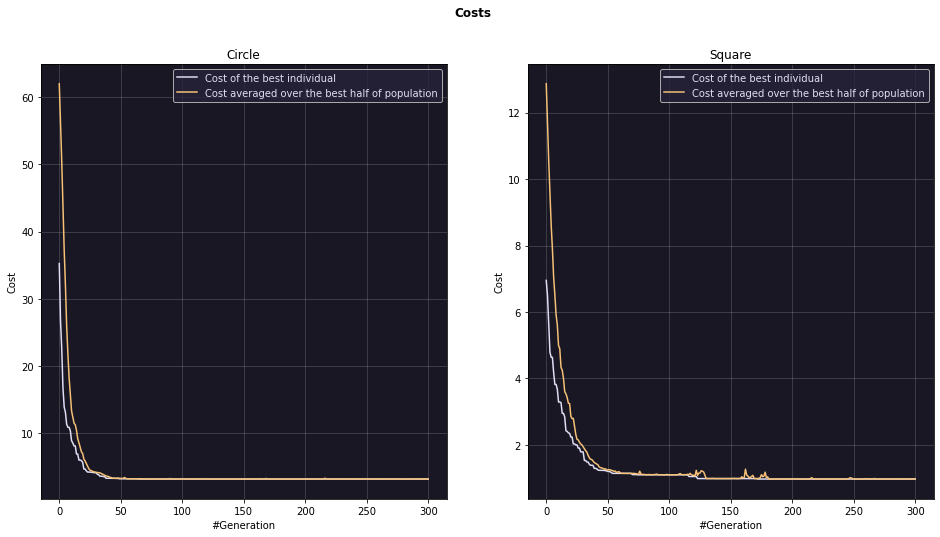

In [4]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('Costs', weight='bold')

#Circle
plt.subplot(121)
plt.title("Circle")
plt.xlabel('#Generation')
plt.ylabel('Cost')
fig.axes[0].set_facecolor(bg1)
##Best cost
data = np.genfromtxt("out/091-bestcost_circle.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el1, label="Cost of the best individual")
##Ave cost
data = np.genfromtxt("out/091-besthalfcost_circle.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el2, label="Cost averaged over the best half of population")

Legend()
plt.grid(alpha=0.3)

#Square
plt.subplot(122)
plt.title("Square")
plt.xlabel('#Generation')
plt.ylabel('Cost')
fig.axes[1].set_facecolor(bg1)
##Best cost
data = np.genfromtxt("out/091-bestcost_square.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el1, label="Cost of the best individual")
##Ave cost
data = np.genfromtxt("out/091-besthalfcost_square.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]
plt.plot(x,y,color=el2, label="Cost averaged over the best half of population")

Legend()
plt.grid(alpha=0.3)

plt.show()


After more or less 150 generation the cost converges.

Here we plot the first proposed path and the best path found. The red dot represent the starting point, the yellow one indicates the second visited city in order to visualize the verse of percorrence

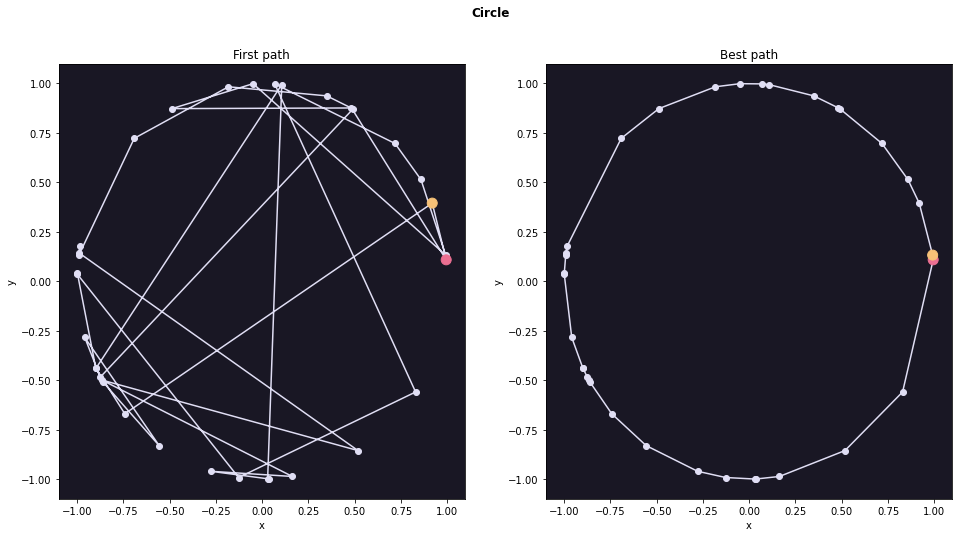

In [7]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('Circle', weight='bold')

plt.subplot(121)
fig.axes[0].set_facecolor(bg1)
data = np.genfromtxt("out/091-firstpath_circle.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)

plt.xlabel('x')
plt.ylabel('y')
plt.title('First path')


plt.subplot(122)
fig.axes[1].set_facecolor(bg1)
data = np.genfromtxt("out/091-bestpath_circle.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best path')
plt.show()

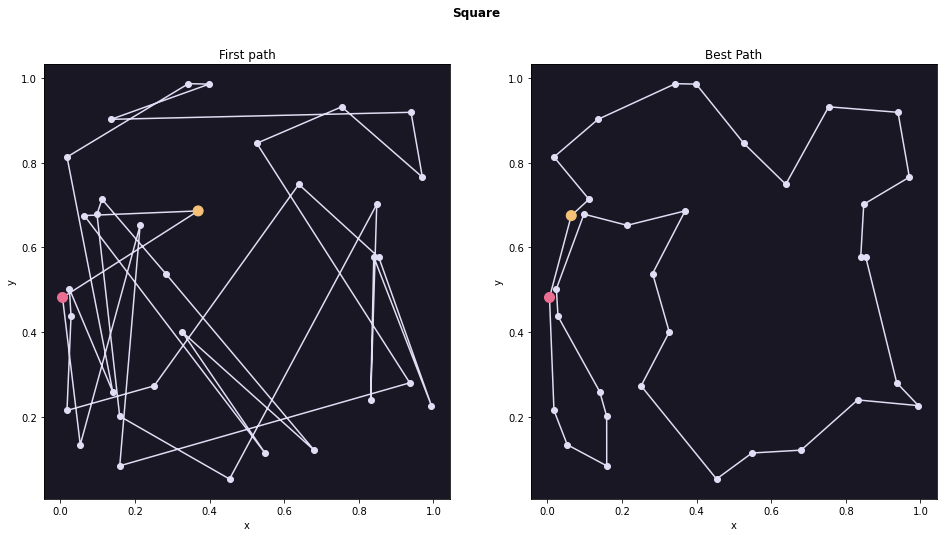

In [6]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('Square', weight='bold')

plt.subplot(121)
fig.axes[0].set_facecolor(bg1)
data = np.genfromtxt("out/091-firstpath_square.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('First path')


plt.subplot(122)
fig.axes[1].set_facecolor(bg1)
data = np.genfromtxt("out/091-bestpath_square.csv", delimiter=",", skip_header=1)
x=np.append(data[:,0],data[0,0])
y=np.append(data[:,1],data[0,1])
plt.plot(x,y, label='test', c=el1, marker="o",zorder=-1)
plt.scatter(x[:2],y[:2], label='test', c=[el3,el2], marker="o",s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best Path')
plt.show()

There are no crossings, so the path found is a good candidate to be the best path

### Conclusion

Those shown are the best results found after many simulations with different parameters. Some insight gained in this excercise:
1. The cost always converge after 150-200 generations, this means that after a certain point it is not the number of generations that matters but the number of individuals;
2. If the mutation probability it too high result are worse, because best solution are disrupted by mutation. The more distruptive the mutation the lower the probability should be;
3. elite selection makes the result worse. If we introduce elite selection before 2/3 of the total generations (that means before the cost has converged to almost a fixed value) the resulting path is likely to have crossings. We found this result by fixing the parameters and running the simulation with different random seeds.